In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [4]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=256)

In [5]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

# VAE

---

In [6]:
# Encoder for real valued signals
class SignalEncoder(nn.Module):
    
    def __init__(self, shape=(1,28,28), latent_dim=20, hidden_dim=500, mean=None, std=None):
        super(SignalEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.in_dim = np.prod(np.array(shape))
        self.hidden_dim = hidden_dim
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(shape))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(shape))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.fc_hidden = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(self.hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear(self.hidden_dim, latent_dim)

    def forward(self, x):
        N = x.shape[0]

        x_norm = (x - self.mean) / self.std

        hidden_state = self.fc_hidden(x_norm.view(N, self.in_dim))
        mu , sigma = self.fc_mu(hidden_state), torch.exp(0.5 * self.fc_sigma(hidden_state))
        
        return mu, sigma


# Decoder for real valued signals        
class SignalDecoder(nn.Module):
    
    def __init__(self, shape=(1,28,28), latent_dim=20, hidden_dim=500):
        super(SignalDecoder, self).__init__()
        
        self.shape = shape
        self.out_dim = np.prod(np.array(shape))
        self.hidden_dim = hidden_dim
        
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.out_dim),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        N = z.shape[0]
        return self.layers(z).view(N, *self.shape)


# VAE combining SignalEncoder and SignalDecoder that samples latent vector z from N(mu, sigma) in training
class SignalVAE(nn.Module):
    
    def __init__(self, shape=(1,28,28), latent_dim=392, hidden_dim=500, mean=None, std=None):
        super(SignalVAE, self).__init__()
        
        print("Version 4")
        
        self.encoder = SignalEncoder(shape=shape, latent_dim=latent_dim, hidden_dim=hidden_dim, mean=None, std=None)
        self.decoder = SignalDecoder(shape=shape, latent_dim=latent_dim, hidden_dim=hidden_dim)
        
    def sample(self, mu, sigma):
        noise = torch.randn_like(sigma)
        
        return mu + noise * sigma
        
    def forward(self, x):
        z_mu, z_sigma = self.encoder(x)
        
        if self.training:
            z = self.sample(z_mu, z_sigma)
        else:
            z = z_mu
        
        return self.decoder(z), z_mu, z_sigma

In [25]:
model_name = "FC-vae784"
z_size = 784
h_size = 500

#vae = SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=h_size)
vae = models.SignalVAE(shape=imsize, latent_dim=z_size, hidden_dim=500)
vae.load_state_dict(torch.load("../cache/models/VAE_MNIST/FC-VAE784Mnist_4.sd"));

Version 4


In [26]:
# Latent z optimization

def genopt(sample_magn, vae, device, init_x=None, steps=5000, lmd=0.0, lr=1.0):
    
    vae.to(device)
    vae.eval()
    
    if init_x is None:
        # TODO: init like PRCGAN
        z = torch.randn((sample_magn.shape[0], z_size), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
    
    opt = optim.Adam([z], lr=lr)
    
    losses = []
    errors = []
    last_out = vae.decoder(z)
    
    with tqdm(total=steps) as pbar:
        for _ in range(steps):
            magn = calc_mags(last_out)
            error = torch.mean((magn - sample_magn) ** 2, dim=(1, 2, 3))
            regul = torch.sum(z ** 2)
            loss = torch.sum(error) + lmd * regul

            opt.zero_grad()
            loss.backward()
            opt.step()

            last_out = vae.decoder(z)

            errors.append(error.detach().cpu().numpy())
            losses.append(loss.item())
            pbar.update()
    
    return last_out.detach().cpu().numpy(), errors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


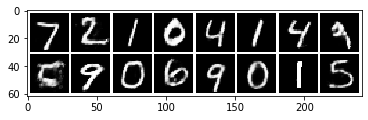

In [27]:
import pickle

e2e_init = pickle.load(open("../cache/e2e/sgnl1-100e.p", "rb"))

plot_grid(e2e_init[:16])

In [28]:
### Latent z optimization ###

num_batches = 4
batch_size = 256
steps = 10000
lmd = 0.0
lr = 1e-1
restarts = 1

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results_total = np.zeros((batch_size * num_batches, restarts, *imsize))
errors = np.full((batch_size * num_batches, restarts, steps), np.inf)

with tqdm(total=restarts*num_batches) as pbar:
    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = calc_mags(test_sample)   
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
        init_x = torch.tensor(e2e_init[batch_size * batch_i : batch_size * batch_i + batch_size], device=device)
        
        for rix in range(restarts):
            cur_out_results, cur_error = genopt(sample_magn=test_magnitudes, vae=vae, device=device,
                                                init_x = init_x, steps=steps, lmd=lmd, lr=lr)

            out_results_total[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = cur_out_results
            errors[batch_size * batch_i : batch_size * batch_i + batch_size, rix] = np.array(cur_error).T

            pbar.update()
        if batch_i + 1 >= num_batches:
            break
            
best_ix = np.argmin(errors[..., -1], axis=-1)
out_results = np.array([out_results_total[i, ix] for i, ix in enumerate(best_ix)])

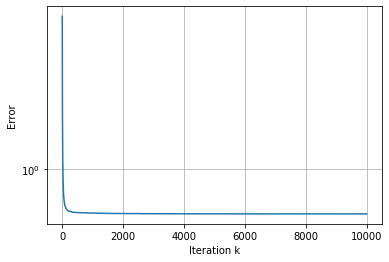

In [31]:
plt.xlabel("Iteration k")
plt.yscale('symlog')
plt.ylabel("Error")
plt.plot(np.mean(errors, axis=(0, 1)))
plt.grid(which='major')
plt.grid(which='minor')
plt.savefig("../out/plots/MNIST_DPR-init_E2E_error-{}-{}s-{}b.png".format(model_name, steps, num_batches), dpi=200)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


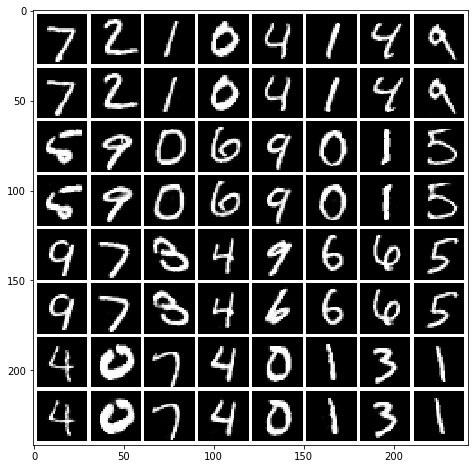

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


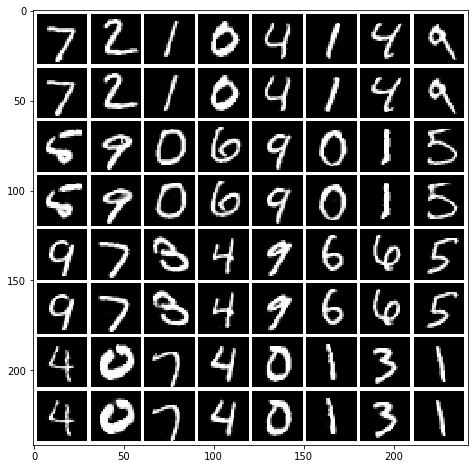

In [32]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),file="../out/MNIST/generative-prior/dpr_E2Einit-{}-{}s-{}b.png"\
          .format(model_name, steps, num_batches))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/generative-prior/dpr_E2Einit-{}-{}s-{}b-reg.png"\
          .format(model_name, steps, num_batches))

In [33]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.020498504464180653, std: 0.026335106001869356
  MAE: 0.0404420419692293, std: 0.03438605335227416
  SSIM: 0.840761249431381, std: 0.1738429620217547
  Sharpness: 0.04953440246947285, std: 0.026110026590482966
  PhCo-MSE: 0.005063319525865036, std: 0.007448823173838091
  PhCo-MAE: 0.019405532770747205, std: 0.013072182803634813
  PhCo-SSIM: 0.9506812772892685, std: 0.06302072358508812
  CroCo-MSE: 0.0046417079247411215, std: 0.0059589894126527276
  CroCo-MAE: 0.018861029051918596, std: 0.011810870787920182
  CroCo-SSIM: 0.954115401445393, std: 0.05273154815802807

Magnitude error:
  MSE Magnitude: 0.5448336940025273, std: 0.4372596436370281

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.02050 | 0.04044 | 0.8408 | 0.04953 | 0.005063 | 0.01941 | 0.9507 | 0.004642 | 0.01886 | 0.9541 | 0.5448 |


# VAE small


### dim(z) = 128

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.02158 | 0.03890 | 0.8370 | 0.02673 | 0.002085 | 0.01028 | 0.9800 | 0.001817 | 0.009952 | 0.9822 | 0.1570 |

### dim(z) = 784

| steps | lr | reg | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 10000 | 0.1 | - | 0.02050 | 0.04044 | 0.8408 | 0.04953 | 0.005063 | 0.01941 | 0.9507 | 0.004642 | 0.01886 | 0.9541 | 0.5448 |



Signal error:
  MSE: 0.021580926202964083, std: 0.02849946598728209
  MAE: 0.038900563344430185, std: 0.03923880267772086
  SSIM: 0.8370058433793156, std: 0.19515574316763987
  Sharpness: 0.026727572546999766, std: 0.023235469691471014
  PhCo-MSE: 0.0020848449875521128, std: 0.0067255669491045784
  PhCo-MAE: 0.010278735424678455, std: 0.01188333979909703
  PhCo-SSIM: 0.9800071565813351, std: 0.05800855676105176
  CroCo-MSE: 0.0018168488070096748, std: 0.005330555401789857
  CroCo-MAE: 0.009952333081201895, std: 0.01068425209157669
  CroCo-SSIM: 0.9821548018809089, std: 0.0491136770997729

Magnitude error:
  MSE Magnitude: 0.15703747386200417, std: 0.23991247169958832

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]
